# GITHUB REPOSITORY SETUP:
    - Github repository: jays-codes/team24
    - Description: Main branch, developent branch, and release branch. 
    - Each team member forked the repository (all branches), and worked (push/pull changes) on the development branch.

# DATA COLLECTION & ELT: 

- Performed ETL (Extract, Load, Transform): 
    - Extracted the following dataset, saved to SQLite database and Github repo: 
        - TTC Streetcar Delay, FY2023 and YTD-09-2024 (https://open.toronto.ca/dataset/ttc-streetcar-delay-data/): directly extracted to Github. 
    
    - Created the following datasets, saved to SQLite database and/or Python dataframes and Github repository:  
        - Ontario Public Holiday, 2023 and 2024 (https://excelnotes.com/holidays-ontario-2023/ and https://excelnotes.com/holidays-ontario-2024): no file available, only information online. We manually created the datasets in .csv and saved to Github. 
        - Line route (https://www.ttc.ca/routes-and-schedules/listroutes/streetcar): no file available, only information online. We manually created the datasets in .csv and saved to Github.  
    
    - Loaded: 
        - Loaded the data to SQLite database 
        - From SQLite database, loaded to Python Panda dataframe. 
   
    - Transformed: 
        - Predictors:
            - Day (3 categories - weekday, weekend, holiday)
            - Holiday (12 categorical values)
            - Time (4 categories - morning, afternoon, evening, night)
            - Peak time (3 categories – peak time morning, peak time afternoon, no)
            - Line (4 categories – regular, special, night, others (bus substitute))
            - Location (1679 unique locations)
            - Bound (4 categorical – north, south, west, east)
            - Vehicle (1012 vehicles)
            - Incident category (13 categories)
        
        - Response variable:
            - Min Delay category (3 categories – short, medium, long)
   
The tasks were done by: Jay Menarco. See codes below.


In [2]:
#Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd


In [3]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [4]:

# Check if __file__ is defined
if '__file__' in globals():
    # Get the directory two levels up from the current script
    base_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
else:
    # Fallback for environments where __file__ is not defined
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    
    # Construct the relative path to the database
db_name = os.path.join(base_dir, 'data', 'streetcardelaydb.db')
table_name = 'Streetcar_Delay_Data'  # Replace with your table name

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data from SQLite database
df = load_from_db(db_name, table_name)

# Convert Incident_Date to datetime
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get isHoliday, isWeekend, and isEndOfMth columns
date_table_name = 'Date'  # Replace with your date table name
date_df = load_from_db(db_name, date_table_name)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'isHoliday', 'isWeekend', 'isEndOfMth']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)


# Load Line table to get lineType
line_table_name = 'Line'  # Replace with your line table name
line_df = load_from_db(db_name, line_table_name)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineType']], left_on='line', right_on='lineId', how='left')

#for lineType that has not been set, set it to 4
df['lineType'] = df['lineType'].fillna(4)

# Load Delay table to get delayType
delay_table_name = 'Delay'  # Replace with your delay table name
delay_df = load_from_db(db_name, delay_table_name)

    # Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Display the DataFrame
df.head()


,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,isHoliday,isWeekend,isEndOfMth,lineId,lineType,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,1,1,0,505,2.0,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,1,1,0,504,2.0,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,1,1,0,504,2.0,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,1,1,0,510,2.0,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,1,1,0,506,2.0,2


# FEATURE ENGINEERING 

Tasks were done by: Ly Nguyen 

In [5]:
# Display exploratory statistics
df.describe()

,incident_date,min_delay,min_gap,isHoliday,isWeekend,isEndOfMth,lineType,delayType
count,21742,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000
mean,2023-11-17 14:32:47.730659584,18.185494,27.249885,0.027504,0.282771,0.032978,2.017708,2.133014
min,2023-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,2023-11-24 00:00:00,10.000000,20.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,2024-04-15 00:00:00,15.000000,24.000000,0.000000,1.000000,0.000000,2.000000,2.000000
max,2024-09-30 00:00:00,960.000000,968.000000,1.000000,1.000000,1.000000,4.000000,3.000000
std,NaN,37.272247,39.340414,0.163552,0.450356,0.178582,0.261982,0.561122


In [6]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  isHoliday      21742 non-null  int64         
 11  isWeekend      21742 non-null  int64         
 12  isEndOfMth     21742 non-null  int64         
 13  lineId         21574 non-null  object        
 14  lineType       21742 non-null  float64       
 15  delayType      2174

Observation: we have plenty of data (>20,000 observations) and only less than 2,000 NULL values, we can remove NULL values without significant impact.

In [7]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
isHoliday           2
isWeekend           2
isEndOfMth          2
lineId             16
lineType            4
delayType           3
dtype: int64

Observation: 
- The 'bound' variable shows 8 unique values - which is wrong. It should be 4 ('N' North, 'S' South, 'W' West, 'E' East). 
- The rest looks okay.

Pre-processing / Feature Engineering work is below. 

In [8]:
# Convert incident_time to datetime
df['incident_time'] = pd.to_datetime(df['incident_time'], format='%H:%M').dt.time

# Define function to categorize time
def categorize_time(time):
    if time >= pd.to_datetime('06:30').time() and time <= pd.to_datetime('09:30').time():
        return 1
    elif time >= pd.to_datetime('10:00').time() and time <= pd.to_datetime('14:00').time():
        return 2
    elif time >= pd.to_datetime('16:30').time() and time <= pd.to_datetime('19:00').time():
        return 3
    else:
        return 4

# Apply function to create new column "timeType"
df['timeType'] = df['incident_time'].apply(categorize_time)


# Clean and factorize columns: location, bound, incident, vehicle, day_of_week
# Define a helper function
def clean_and_factorize(df, column_name, valid_values=None):
    # Remove leading and trailing spaces
    df[column_name] = df[column_name].str.strip()
    
    # Drop null values
    df = df.dropna(subset=[column_name])
    
    # If valid values are provided, filter the dataframe
    if valid_values:
        df = df[df[column_name].isin(valid_values)]
    
    # Assign unique numeric values
    df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
    
    return df

# Apply the function to each column
df = clean_and_factorize(df, 'location')
df = clean_and_factorize(df, 'incident')
df = clean_and_factorize(df, 'vehicle')
df = clean_and_factorize(df, 'day_of_week')
df = clean_and_factorize(df, 'line')
df = clean_and_factorize(df, 'bound', valid_values=['N', 'S', 'W', 'E'])


# Display the DataFrame
df.head()


C:\Users\DELL\AppData\Local\Temp\ipykernel_9008\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_9008\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1


,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,...,lineId,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,2023-01-01,505,02:40:00,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,...,505,2.0,2,4,1,1,1,1,1,1
1,2023-01-01,504,02:52:00,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,...,504,2.0,2,4,2,2,2,1,2,1
2,2023-01-01,504,02:59:00,Sunday,KING AND BATHURST,Held By,25,35,E,4560,...,504,2.0,3,4,2,1,3,1,2,2
3,2023-01-01,510,05:38:00,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,...,510,2.0,2,4,3,3,4,1,3,3
5,2023-01-01,501,08:52:00,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,...,501,2.0,2,1,5,2,6,1,5,1


In [9]:
# Verify that there are 4 'bound' unique values: 
df.nunique()

incident_date      639
line                42
incident_time     1438
day_of_week          7
location          2936
incident            14
min_delay          246
min_gap            268
bound                4
vehicle           1537
isHoliday            2
isWeekend            2
isEndOfMth           2
lineId              16
lineType             4
delayType            3
timeType             4
location_id       2936
incident_id         14
vehicle_id        1537
day_of_week_id       7
line_id             42
bound_id             4
dtype: int64

In [10]:
# Verify that the NULL objects have been dropped. 
null_counts = df.isnull().sum()
print(null_counts)

incident_date       0
line                0
incident_time       0
day_of_week         0
location            0
incident            0
min_delay           0
min_gap             0
bound               0
vehicle             0
isHoliday           0
isWeekend           0
isEndOfMth          0
lineId            104
lineType            0
delayType           0
timeType            0
location_id         0
incident_id         0
vehicle_id          0
day_of_week_id      0
line_id             0
bound_id            0
dtype: int64


Observation: the "lineId" column was created as primary key to join tables only. We can drop this, along with other non-beneficial predictors - see codes below.

In [11]:
# Drop the following columns: incident_date, incident_time, min_gap, isEndOfMth, lineID. min_delay
df_cleaned = df.drop(['incident_date','incident_time', 'min_gap', 'isEndOfMth', 'lineId'], axis=1)

# Verify the columns are dropped
df_cleaned.head()

,line,day_of_week,location,incident,min_delay,bound,vehicle,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,505,Sunday,BROADVIEW AND GERRARD,Held By,15,W,4460,1,1,2.0,2,4,1,1,1,1,1,1
1,504,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,W,4427,1,1,2.0,2,4,2,2,2,1,2,1
2,504,Sunday,KING AND BATHURST,Held By,25,E,4560,1,1,2.0,3,4,2,1,3,1,2,2
3,510,Sunday,SPADINA AND DUNDAS,Security,15,S,4449,1,1,2.0,2,4,3,3,4,1,3,3
5,501,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,W,8015,1,1,2.0,2,1,5,2,6,1,5,1


Note: 
- The unique ids columns (ie. location_id, vehicle_id, etc.) will be used in the predicitve models. 
- We are keeping names of predictors (e.g., line, day_of_week, etc) to re-map them to their unique ids later during the data visualization.

In [12]:
# Reviewing the data types and counts to make sure everything looks okay.
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19083 entries, 0 to 21741
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   line            19083 non-null  object 
 1   day_of_week     19083 non-null  object 
 2   location        19083 non-null  object 
 3   incident        19083 non-null  object 
 4   min_delay       19083 non-null  int64  
 5   bound           19083 non-null  object 
 6   vehicle         19083 non-null  object 
 7   isHoliday       19083 non-null  int64  
 8   isWeekend       19083 non-null  int64  
 9   lineType        19083 non-null  float64
 10  delayType       19083 non-null  int64  
 11  timeType        19083 non-null  int64  
 12  location_id     19083 non-null  int64  
 13  incident_id     19083 non-null  int64  
 14  vehicle_id      19083 non-null  int64  
 15  day_of_week_id  19083 non-null  int64  
 16  line_id         19083 non-null  int64  
 17  bound_id        19083 non-null  int6

In [13]:
# Reviewing the dataframe to make sure everythign looks okay. 
df_cleaned.describe()

,min_delay,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
count,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000,19083.000000
mean,17.675890,0.026987,0.282398,2.013258,2.123041,3.137505,566.656553,5.544097,337.822879,4.081067,4.940261,1.997380
std,36.056052,0.162051,0.450178,0.242230,0.559109,1.091198,725.087463,2.966921,355.018269,1.990829,4.649917,1.003449
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,90.000000,3.000000,98.000000,2.000000,2.000000,1.000000
50%,10.000000,0.000000,0.000000,2.000000,2.000000,4.000000,247.000000,5.000000,209.000000,4.000000,4.000000,2.000000
75%,14.000000,0.000000,1.000000,2.000000,2.000000,4.000000,704.000000,8.000000,408.000000,6.000000,5.000000,2.000000
max,960.000000,1.000000,1.000000,4.000000,3.000000,4.000000,3197.000000,14.000000,1578.000000,7.000000,44.000000,4.000000


We now graph whisker plot, influence plot, and histogram: to remove outliers of min_delay that significantly skew our result.

# CLASS BALANCE

In [14]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12829
3     4301
1     1953
Name: count, dtype: int64


Observation: 
- Class 1 (Short Delay Time): 1,953 observations. 
- Class 2 (Expected Delay Time): 12,829 observations. 
- Class 3 (Long Delay Time): 4,301 observations. 

There is a significant class imbalance, where Class 2 (Expected Delay Time) significantly dominates the dataset. 

# Whisker plot

In [15]:
# Import libraries for data visualization to graph whisker plot, influence plot, and histogram. 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

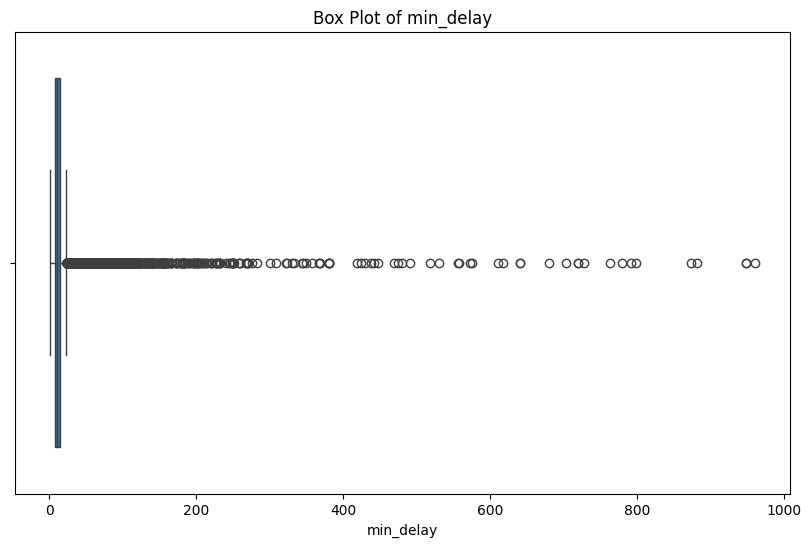

In [16]:
# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['min_delay'])
plt.title('Box Plot of min_delay')
plt.show()


Observation: Most of the observations fall in low min_delay values. However, we decide to keep the values outside of the Whisker plots - as these are the data points with the longest delay time, meaning they can be most disruptive. We keep them here because TTC may benefit from gauging into the causes of these significant and disruptive delays. 

# Histogram

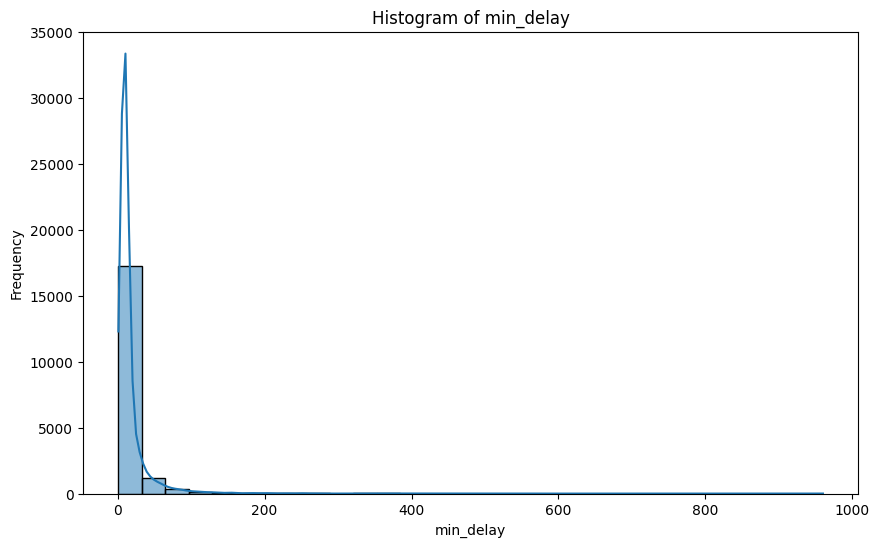

In [17]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()


Observation: The dataset is skewed to the right but most of the observations are within the bell curve. We can use this dataset for the analysis and predictive model.

# Influence plot

In [18]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit the Regression Model and Calculate Influence Measures:

# Add a constant to the model
X = sm.add_constant(df_cleaned['min_delay'])
model = sm.OLS(df_cleaned['min_delay'], X).fit()

# Get influence measures
influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]


# Step 2: Identify Top 4 Points with Highest Leverage:

# Identify the top 4 points with the highest leverage values
top_4_high_leverage_points = np.argsort(leverage)[-4:]

# Print the actual indices of these points
actual_indices = df_cleaned.index[top_4_high_leverage_points]
print("Top 4 High Leverage Points Indices:", actual_indices)

# Show the top 4 high leverage points
df_cleaned.loc[actual_indices]


Top 4 High Leverage Points Indices: Index([5146, 5194, 5172, 5412], dtype='int64')


,line,day_of_week,location,incident,min_delay,bound,vehicle,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
5146,506,Monday,COXWELL AND GERRARD,Diversion,882,W,8739,0,0,2.0,3,1,709,9,868,2,4,1
5194,506,Tuesday,VICTORIA PARK STATION,Diversion,948,W,8765,0,0,2.0,3,4,1121,9,885,3,4,1
5172,506,Tuesday,COXWELL AND LOWER GERR,Diversion,948,W,0,0,0,2.0,3,1,7,9,36,3,4,1
5412,506,Monday,VICTORIA PARK STATION,Diversion,960,W,8732,0,0,2.0,3,3,1121,9,905,2,4,1


Observation: The 4 outliers that can significantly impacts the result give unusually long min_delay minutes from 882 minutes to 960 minutes. 
We can plot them in the influence plot.

c:\ProgramData\miniconda3\envs\DSI_participant\lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)
c:\ProgramData\miniconda3\envs\DSI_participant\lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


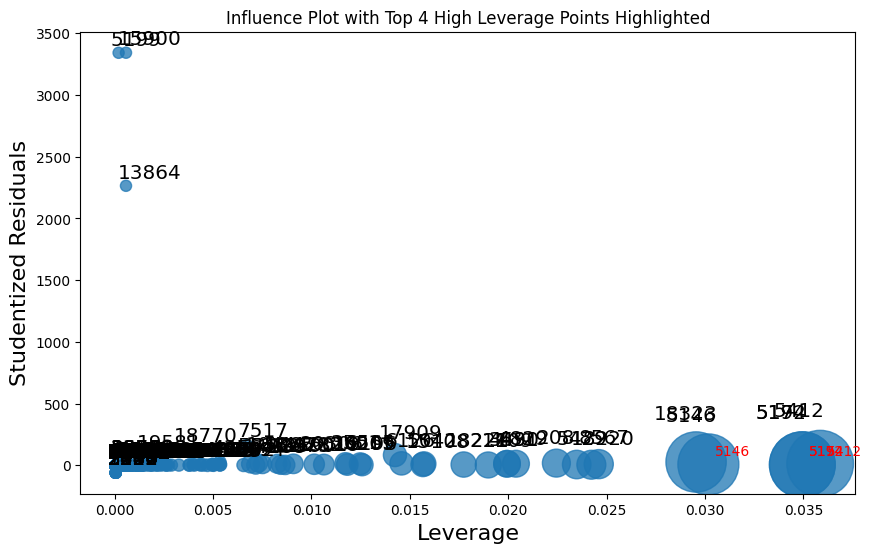

In [19]:
import matplotlib.pyplot as plt

# Create the original influence plot
fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

# Highlight the top 4 high leverage points
for idx in top_4_high_leverage_points:
    ax.annotate(f"{df_cleaned.index[idx]}", 
                xy=(leverage[idx], influence.resid_studentized_internal[idx]),
                xytext=(5, 5), textcoords='offset points', color='red')

plt.title('Influence Plot with Top 4 High Leverage Points Highlighted')
plt.show()


Observation: Usually we would remove the outliers that significantly impacts the results. But since we are going to use Random Forest Classifier - which can handle outliers well (better than other models), we decide to keep them here. We believe TTC may benefit from keeping them, to gauge into the causes of these significant and disruptive delays. 

# PREDICTIVE MODELING : RANDOM FOREST CLASSIFIER

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Encode the delayType to numerical values
df_cleaned['delayType_id'] = pd.factorize(df_cleaned['delayType'])[0]

# Split data into features (X) and target (y)
X = df_cleaned[['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
                'isHoliday', 'isWeekend', 'lineType', 'timeType']]
y = df_cleaned['delayType_id']

# Set random seed for reproducibility
random_seed = 42

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)




# Use GridSearchCV to find the optimal hyperparameters for the Random Forest Classifier

Step-by-Step Approach for Hyperparameter Tuning:
Set Up the Parameter Grid: Define a grid of parameters to search.

Use GridSearchCV: Perform a grid search to find the best combination of parameters.

Train the Model with Optimal Parameters: Use the best parameters to train your final model.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # testing different numbers of trees in the forest: 50 trees, 100 trees, 200 trees. 
    'max_depth': [None, 10, 20, 30], # preventing overfitting by limiting how deep the trees can grow: max 10 levels, 20 levels, 30 levels. 
    'min_samples_split': [2, 5, 10], # further reducing overfitting, by controlling the growth of the trees, by specifying the minimum number of samples required to split an internal node: allowing split even if only 2 samples are present, 5 samples are present, 10 samples are present. 
    'min_samples_leaf': [1, 2, 4] # further reducing overfitting, by controlling the size of the tree, by determining the minimum number of samples required to be at a leaf node: allowing leaves to contain 1 sample, 2 samples, 4 samples. 
}


In [22]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
                    estimator=clf, # select "clf" (Random Forest Classifier - defined above) as the estimator. 
                    param_grid=param_grid, # defines the hyperparameters (defined in the cell above) and their possible values to be searched over. 
                    cv=5, # specifies the number of cross-validation folds to be used: 5. Ie. Split the data into 5 subsets, each taking turn as training set and validation set. The process is repeated 5 tiems. 
                    scoring='accuracy', # specifies the metric "accuracy" as the scoring metric to evaluate the model's performance. Accuracy is the ratio of correctly predicted instances to the total instances.
                    n_jobs=-1) # tells GridSearchCV to use all available CPU cores for computation, speeding up the computation process.

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [23]:
# Best parameters from GridSearchCV
best_params = {'n_estimators': 100, # Number of trees in the forest
               'max_depth': 10, # Maximum depth of the tree
               'min_samples_leaf': 1, # Minimum number of samples required to be at a leaf node
               'min_samples_split': 5, # Minimum number of samples required to split an internal node
                } 

# Initialize and fit the Random Forest Classifier with best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

# RANDOM FOREST CLASSIFIER - apply the optimal parameters found from GridSearch 

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest Classifier with best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

clf.fit(X_train, y_train)

# Predicting the delay types
y_pred = clf.predict(X_test)

# Get feature importances
feature_importances = best_clf.feature_importances_
features = ['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
    'isHoliday', 'isWeekend', 'lineType', 'timeType'
    ]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
1     incident_id    0.364486
2      vehicle_id    0.201985
4         line_id    0.133653
0     location_id    0.115547
8        lineType    0.044851
3  day_of_week_id    0.043852
5        bound_id    0.037412
9        timeType    0.036013
7       isWeekend    0.016658
6       isHoliday    0.005543


# MODEL EVALUATION

# 1) Accuracy, Precision, Recall and F1 Score

In [25]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      3879
           1       0.60      0.38      0.47      1286
           2       0.59      0.27      0.37       560

    accuracy                           0.72      5725
   macro avg       0.64      0.52      0.55      5725
weighted avg       0.70      0.72      0.70      5725



# Interpretation:
- # Precision, Recall, F1-score: 
    - Class 0 (Short Delay Time):

        - Precision: 0.75. Out of all the instances predicted as Class 0, 75% were correct.
        - Recall: 0.93. Out of all the actual Class 0 instances, 93% were correctly predicted.
        - F1-Score: 0.83. The harmonic mean of precision and recall, balancing the two metrics.

    - Class 1 (Expected Delay Time):

        - Precision: 0.67. Out of all the instances predicted as Class 1, 67% were correct.
        - Recall: 0.36. Out of all the actual Class 1 instances, only 36% were correctly predicted.
        - F1-Score: 0.47. This indicates a poorer performance for Class 1 compared to Class 0.

    - Class 2 (Long Delay Time):

        - Precision: 0.66. Out of all the instances predicted as Class 2, 66% were correct.
        - Recall: 0.21. Out of all the actual Class 2 instances, only 21% were correctly predicted.
        - F1-Score: 0.32. This indicates the poorest performance among the three classes.


- # Accuracy:
    - Accuracy: 0.73. Around 73% of the predictions made by the model are correct.


- # Summary:
    - Class 0 performs well, with high precision and recall.
    - Class 1 struggles with recall, meaning many actual Class 1 instances are not being predicted as such.
    - Class 2 has both low precision and recall, indicating it’s challenging for the model to predict.



# 2) CONFUSION MATRIX

In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[3487  303   89]
 [ 773  495   18]
 [ 375   33  152]]


# Intepretation: 
- Counts of DelayType Classes:
    - Class 0 (Short Delay Time): 12829
    - Class 1 (Expected Delay Time): 4301
    - Class 2 (Long Delay Time): 1953

- Correctly Predicted Instances:
    - Class 0 (Short Delay Time): 3616 correctly predicted out of 12829
    - Class 1 (Expected Delay Time): 468 correctly predicted out of 4301
    - Class 2 (Long Delay Time): 120 correctly predicted out of 1953


# Conclusion on the predictive model's performance: 

Our predictive model performs well for Class 0 (Short Delay Type) with high Precision and Recall scores. 

However, due to the significant dominance of Class 0, we recommend to and additional separate in-depth study into each delay-type class to handle Class Imbalance as well as explore other predicitve models - Regressors and Classifiers. However, that work is outside of our current project scope. 


    

# INTERPRETATION & DATA VISUALIZATION

In [27]:
# Create mappings from IDs to original names
location_mapping = dict(zip(df_cleaned['location_id'], df_cleaned['location']))
incident_mapping = dict(zip(df_cleaned['incident_id'], df_cleaned['incident']))
vehicle_mapping = dict(zip(df_cleaned['vehicle_id'], df_cleaned['vehicle']))
day_of_week_mapping = dict(zip(df_cleaned['day_of_week_id'], df_cleaned['day_of_week']))
line_mapping = dict(zip(df_cleaned['line_id'], df_cleaned['line']))
bound_mapping = dict(zip(df_cleaned['bound_id'], df_cleaned['bound']))


In [28]:
# Map feature names back to original using the dictionaries
mapped_features = []

for feature in importance_df['Feature']:
    if feature == 'location_id':
        mapped_features.append('location')
    elif feature == 'incident_id':
        mapped_features.append('incident')
    elif feature == 'vehicle_id':
        mapped_features.append('vehicle')
    elif feature == 'day_of_week_id':
        mapped_features.append('day_of_week')
    elif feature == 'line_id':
        mapped_features.append('line')
    elif feature == 'bound_id':
        mapped_features.append('bound')
    else:
        mapped_features.append(feature)
        
importance_df['Mapped Feature'] = mapped_features


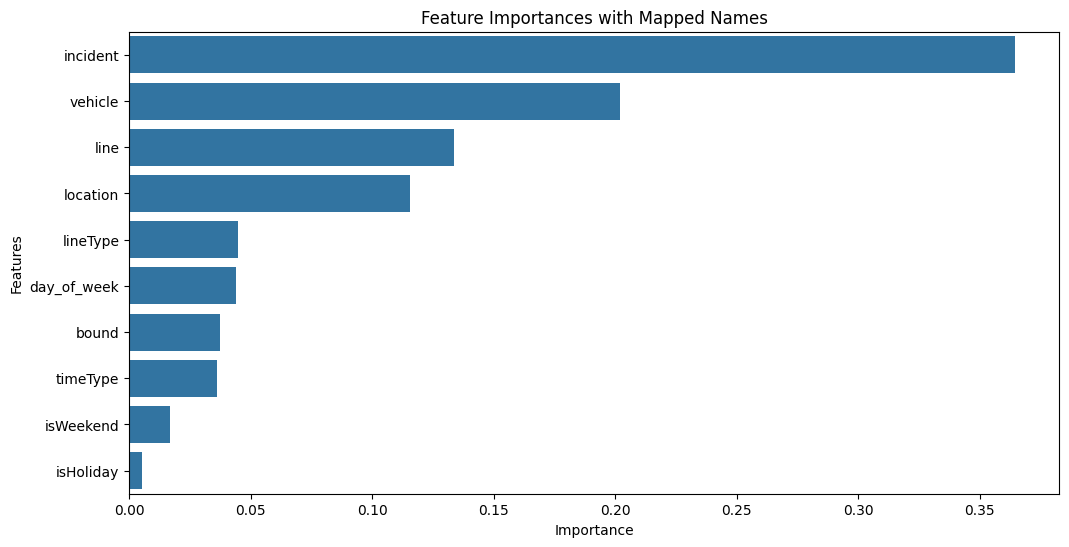

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Feature Importances with mapped feature names
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Mapped Feature'])
plt.title('Feature Importances with Mapped Names')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# ANALYSIS
Identify which specific values within your important features (like "incident" and "location") are predictive of each delayType.

Approach:
Extract and Analyze Data: For the top features (incident, location, etc.), analyze the distribution of delayType within these features.

Visualization: Create plots to visualize which specific values of these features are highly predictive for each delayType.

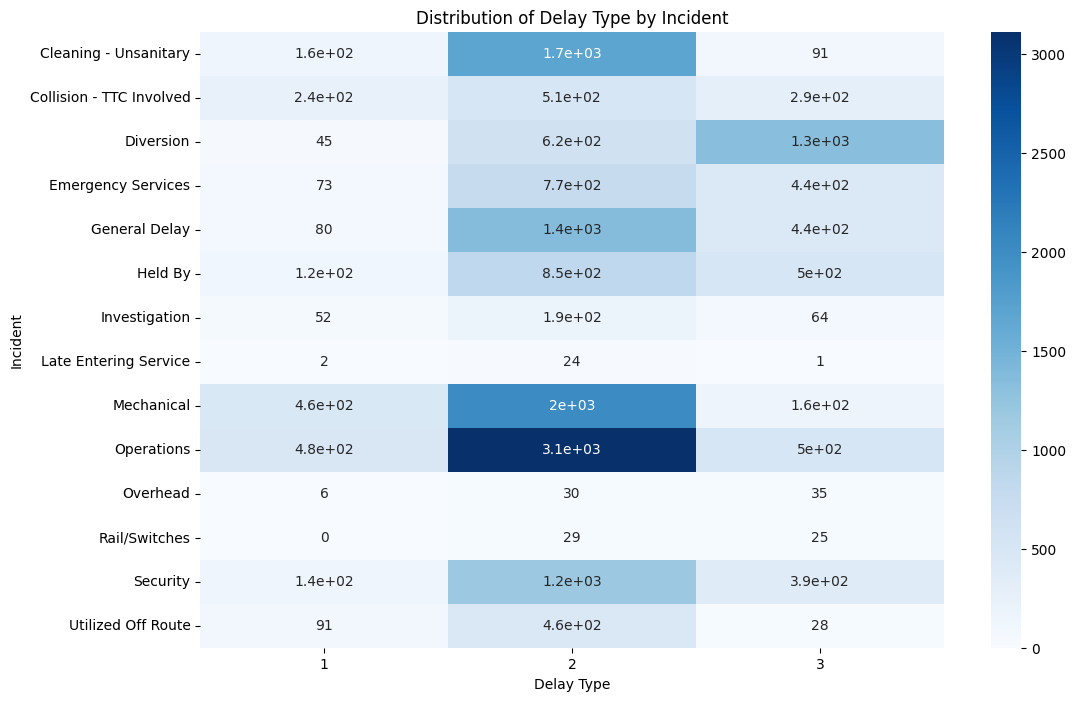

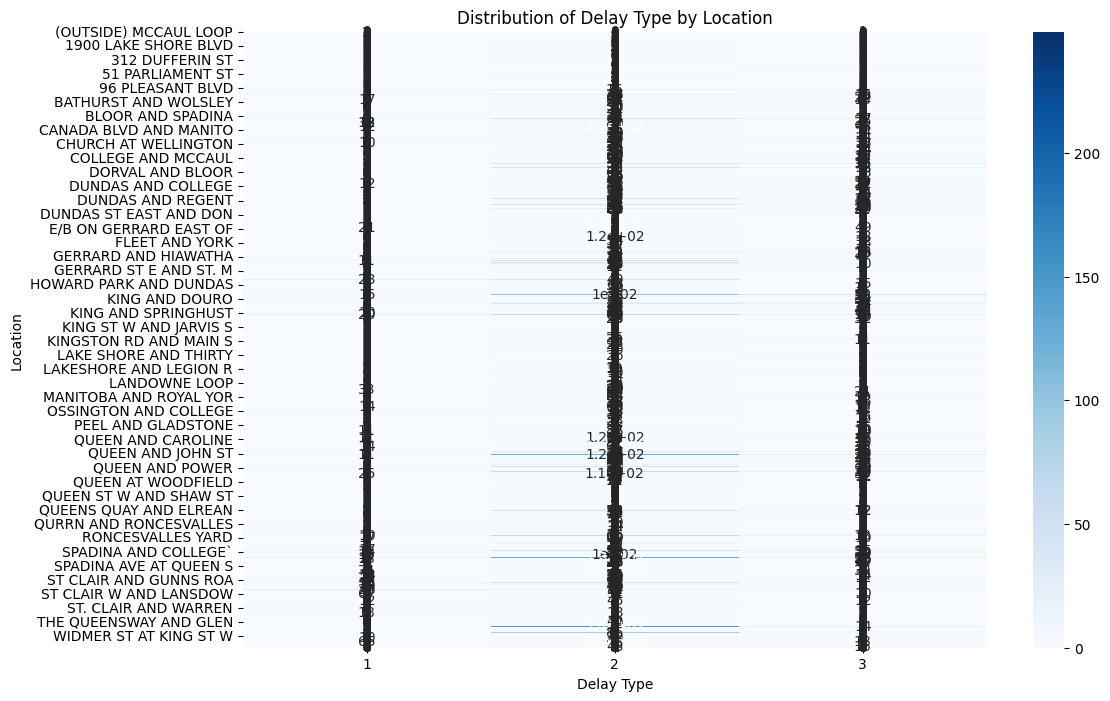

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Analyzing the distribution of delayType for the top feature: incident
incident_delay_type = df_cleaned.groupby(['incident', 'delayType']).size().unstack().fillna(0)

# Plotting the distribution of delayType for incidents
plt.figure(figsize=(12, 8))
sns.heatmap(incident_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Incident')
plt.xlabel('Delay Type')
plt.ylabel('Incident')
plt.show()

# Analyzing the distribution of delayType for the second top feature: location
location_delay_type = df_cleaned.groupby(['location', 'delayType']).size().unstack().fillna(0)

# Plotting the distribution of delayType for locations
plt.figure(figsize=(12, 8))
sns.heatmap(location_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Location')
plt.xlabel('Delay Type')
plt.ylabel('Location')
plt.show()


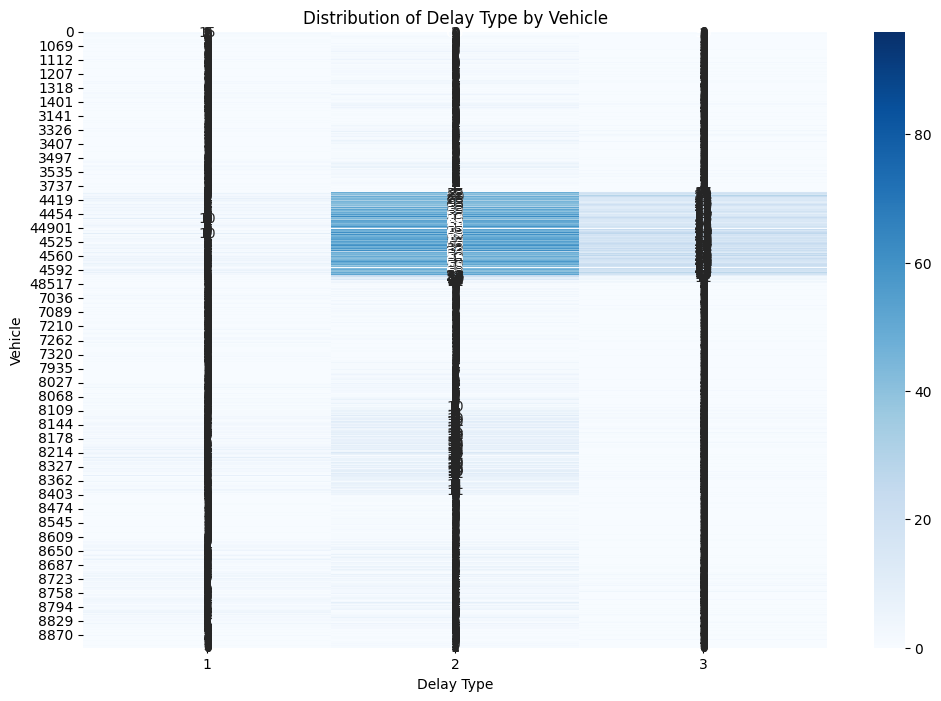

In [33]:
# Heatmap for Vehicles
vehicle_delay_type = df_cleaned.groupby(['vehicle', 'delayType']).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(vehicle_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Vehicle')
plt.xlabel('Delay Type')
plt.ylabel('Vehicle')
plt.show()
